# CanESM5 tas trend maps look
## tas trends

### history
-  NCS for talk

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import cartopy.crs as ccrs
import cartopy
from pprint import pprint
import matplotlib.path as mpath
import os
from datetime import datetime
from cdo import Cdo
from scipy.stats import norm
import cmocean
import modules.basic_stats as bst
import modules.plotting_module as pltm
import sqlite3

cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
%store -r tr_start 
%store -r tr_end
%store -r color_dict
%store -r label_fontsize
%store -r legend_fontsize

ts_start  = '1850-01-01'
ts_end    = '2019-01-01'
ts_startdate = datetime.strptime(ts_start,'%Y-%m-%d')
ts_enddate   = datetime.strptime(ts_end,'%Y-%m-%d')

refperiod_start = '1951-01-01'
refperiod_end   = '1980-01-01'
refperiod_startdate = datetime.strptime(refperiod_start,'%Y-%m-%d')
refperiod_enddate   = datetime.strptime(refperiod_end,'%Y-%m-%d')

his_start = tr_start
his_end = tr_end
his_startdate = datetime.strptime(his_start,'%Y-%m-%d')
his_enddate   = datetime.strptime(his_end,'%Y-%m-%d')

zm_start  = tr_start
zm_end    = tr_end
zm_startdate = datetime.strptime(zm_start,'%Y-%m-%d')
zm_enddate   = datetime.strptime(zm_end,'%Y-%m-%d')

obs_dir1    = 'input_data/obs_dir1'
CanESM5_dir = 'input_data/CanESM5_cmip_dir/historical/'
CanESM2_dir = 'input_data/CanESM2_combined_ensemble/tas/'


In [3]:
#make dictionaries with data for each model/obs 

CanESM5zm = {}
i=0
for root, subdirs, files in os.walk(CanESM5_dir):
    #narrow down the walk
    if 'Amon' in subdirs:
        subdirs[:] = ['Amon']
    if 'tas' in subdirs:
        subdirs[:] = ['tas']
    for filename in files:
        var, tab, model, expt, rl, grid, dates = filename.split('_')
        ds = xr.open_dataset(os.path.join(root,filename))['tas']
        ann_means = pltm.get_month_weighted_annual_means(ds, 'noleap', zm_start, zm_end)
        cov,cor,slope,intercept,pval,stderr = (pltm.Linregress3D(ann_means.year, ann_means))
        CanESM5zm[rl] = {'ds':ds,'global_trend':slope}

        # sea-ice
CanESM5zm_si = {}
i=0
for root, subdirs, files in os.walk(CanESM5_dir):
    #narrow down the walk
    if 'SImon' in subdirs:
        subdirs[:] = ['SImon']
    if 'siconc' in subdirs:
        subdirs[:] = ['siconc']
    for filename in files:
        var, tab, model, expt, rl, grid, dates = filename.split('_')
        ds = xr.open_dataset(os.path.join(root,filename))['siconc']
        ann_means = pltm.get_month_weighted_annual_means(ds, 'noleap', zm_start, zm_end)
        cov,cor,slope,intercept,pval,stderr = (pltm.Linregress3D(ann_means.year, ann_means))
        CanESM5zm_si[rl] = {'ds':ds,'global_trend':slope}

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/scipy/s

In [4]:
CanESM5global_trends = xr.concat([CanESM5zm[rel]['global_trend'] for rel in CanESM5zm],dim='realization')
CanESM5global_trends = pltm.addCyclicPoint(CanESM5global_trends, dim='lon')*10

CanESM5global_trends_si = xr.concat([CanESM5zm_si[rel]['global_trend'] for rel in CanESM5zm_si],dim='realization')
#CanESM5global_trends_si = pltm.addCyclicPoint(CanESM5global_trends_si, dim='lon')*10

In [ ]:
areacella = xr.open_dataset('input_data/CanESM5_cmip_dir/piControl/r1i1p1f1/fx/areacella/gn/v20190429/areacella_fx_CanESM5_piControl_r1i1p1f1_gn.nc')['areacella']

In [ ]:
glob_area = areacella.sum(dim=['lon','lat'])
gmt = CanESM5global_trends.sum(dim=['lon','lat'])/glob_area

In [7]:
CanESM5global_trends

<xarray.DataArray (realization: 50, lat: 64, lon: 129)>
array([[[0.384796, 0.384938, ..., 0.385074, 0.384796],
        [0.42995 , 0.435063, ..., 0.425794, 0.42995 ],
        ...,
        [1.479126, 1.489221, ..., 1.468096, 1.479126],
        [1.294781, 1.288817, ..., 1.290955, 1.294781]],

       [[0.427416, 0.427237, ..., 0.430286, 0.427416],
        [0.423788, 0.419958, ..., 0.427697, 0.423788],
        ...,
        [1.474418, 1.475467, ..., 1.478524, 1.474418],
        [1.527213, 1.527479, ..., 1.522793, 1.527213]],

       ...,

       [[0.17844 , 0.183596, ..., 0.176223, 0.17844 ],
        [0.237964, 0.244409, ..., 0.23339 , 0.237964],
        ...,
        [1.228462, 1.236963, ..., 1.211734, 1.228462],
        [1.161072, 1.165491, ..., 1.152904, 1.161072]],

       [[0.346213, 0.349091, ..., 0.341816, 0.346213],
        [0.349955, 0.366276, ..., 0.334764, 0.349955],
        ...,
        [0.940112, 0.944606, ..., 0.932524, 0.940112],
        [0.951616, 0.952577, ..., 0.951263, 0.95

In [ ]:
5, 40

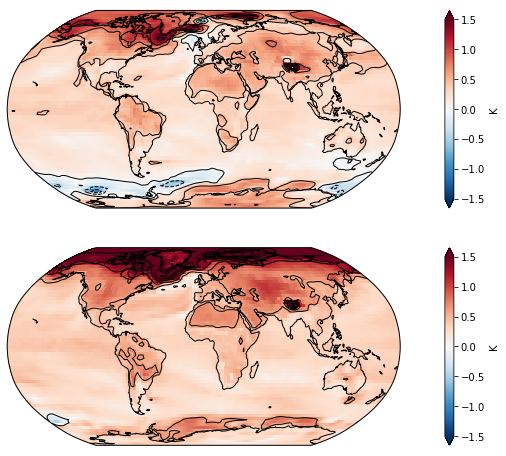

In [8]:
#trend map
fig = plt.figure(figsize=(16,8))


vmin = -1.5
vmax = 1.5 
cmap = plt.cm.RdBu_r


ax2 = plt.subplot(2,1,1,projection=ccrs.Robinson())  
im2 = ax2.pcolormesh(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends[5,:,:],vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
ax2.contour(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends[5,:,:], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im2, ax=ax2, extend='both', label= 'K')

ax3 = plt.subplot(2,1,2,projection=ccrs.Robinson())  
im3 = ax3.pcolormesh(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends[40,:,:],vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
ax3.contour(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends[40,:,:], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im2, ax=ax3, extend='both', label='K')

for ax in [ax2,ax3]:
    ax.coastlines()
    
#plt.savefig('plots/fig-X26_tas_trends_maps.png', bbox_inches='tight')

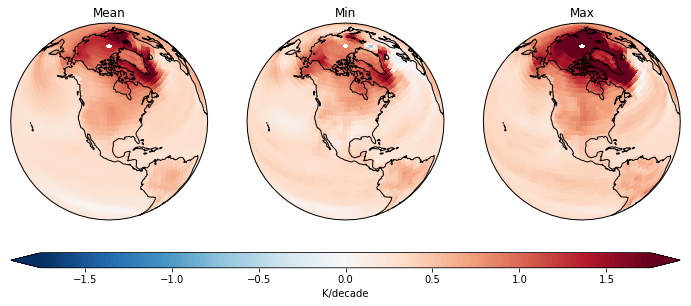

In [9]:
#trend map
fig = plt.figure(figsize=(12,12))


vmin = -1.75
vmax = 1.75
cmap = plt.cm.RdBu_r

ax1 = plt.subplot(1,3,1,projection=ccrs.Orthographic(central_latitude=40, central_longitude=-100))
im1 = ax1.pcolormesh(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends.mean(dim='realization'),vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())

ax2 = plt.subplot(1,3,2,projection=ccrs.Orthographic(central_latitude=40, central_longitude=-100))
im2 = ax2.pcolormesh(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends[5,:,:],vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
#ax2.contour(CanESM5_trend.lon,CanESM5_trend.lat,CanESM5global_trends[5,:,:], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
#plt.colorbar(im2, ax=ax2, extend='both', label= 'K/decade')

ax3 = plt.subplot(1,3,3,projection=ccrs.Orthographic(central_latitude=40, central_longitude=-100))  
im3 = ax3.pcolormesh(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends[40,:,:],vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
#ax3.contour(CanESM5_trend.lon,CanESM5_trend.lat,CanESM5global_trends[40,:,:], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im2, ax=[ax1,ax2,ax3], extend='both', label='K/decade', orientation='horiztonal', pad=0.05, aspect=40)

titles=['Mean', 'Min', 'Max']
for i,ax in enumerate([ax1,ax2,ax3]):
    ax.coastlines()
    ax.set_title(titles[i])
    
plt.savefig('neil/tas_trends_maps.png', bbox_inches='tight')

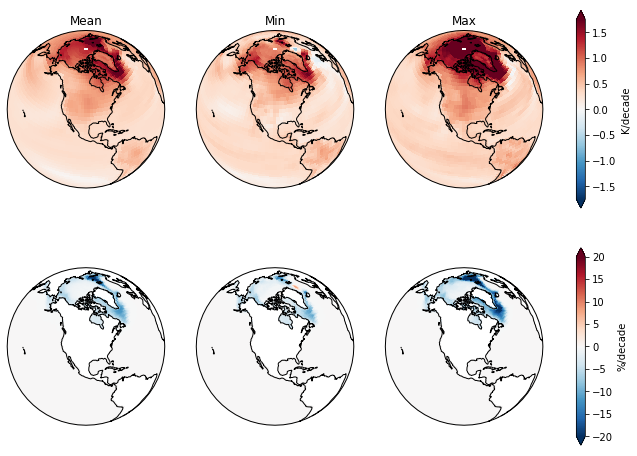

In [29]:
#trend map
fig = plt.figure(figsize=(12,8))

vmin = -1.75
vmax = 1.75
cmap = plt.cm.RdBu_r

ax1 = plt.subplot(2,3,1,projection=ccrs.Orthographic(central_latitude=40, central_longitude=-100))
im1 = ax1.pcolormesh(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends.mean(dim='realization'),vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())

ax2 = plt.subplot(2,3,2,projection=ccrs.Orthographic(central_latitude=40, central_longitude=-100))
im2 = ax2.pcolormesh(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends[5,:,:],vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
#ax2.contour(CanESM5_trend.lon,CanESM5_trend.lat,CanESM5global_trends[5,:,:], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
#plt.colorbar(im2, ax=ax2, extend='both', label= 'K/decade')

ax3 = plt.subplot(2,3,3,projection=ccrs.Orthographic(central_latitude=40, central_longitude=-100))  
im3 = ax3.pcolormesh(CanESM5global_trends.lon,CanESM5global_trends.lat,CanESM5global_trends[40,:,:],vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
#ax3.contour(CanESM5_trend.lon,CanESM5_trend.lat,CanESM5global_trends[40,:,:], 10, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
plt.colorbar(im2, ax=[ax1,ax2,ax3], extend='both', label='K/decade', pad=0.05)

titles=['Mean', 'Min', 'Max']
for i,ax in enumerate([ax1,ax2,ax3]):
    ax.set_title(titles[i])
    
vmax=20
vmin=-20
cmap='RdBu_r'
ax4 = plt.subplot(2,3,4,projection=ccrs.Orthographic(central_latitude=40, central_longitude=-100))
im4 = ax4.pcolormesh(CanESM5global_trends_si.longitude,CanESM5global_trends_si.latitude,CanESM5global_trends_si.mean(dim='realization')*10,vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())

ax5 = plt.subplot(2,3,5,projection=ccrs.Orthographic(central_latitude=40, central_longitude=-100))
im5 = ax5.pcolormesh(CanESM5global_trends_si.longitude,CanESM5global_trends_si.latitude,CanESM5global_trends_si[5,:,:]*10,vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())

ax6 = plt.subplot(2,3,6,projection=ccrs.Orthographic(central_latitude=40, central_longitude=-100))
im6 = ax6.pcolormesh(CanESM5global_trends_si.longitude,CanESM5global_trends_si.latitude,CanESM5global_trends_si[40,:,:]*10,vmin=vmin, vmax=vmax,cmap=cmap,transform=ccrs.PlateCarree())
plt.colorbar(im6, ax=[ax4,ax5,ax6], extend='both', label='%/decade', pad=0.05)

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.coastlines()

plt.savefig('neil/tas-sic_trends_maps.png', bbox_inches='tight')

<xarray.DataArray ()>
array(-3.602029)
Coordinates:
    type     |S7 b'sea_ice'